In [25]:
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

from sklearn.decomposition import PCA

from utils.data import read_dataset
from utils.image_preprocessing import preprocess_dataset
from utils.hyperparameter_optimizer import optimize_hyperparameters

%matplotlib inline

# Loading data

In [ ]:
X_raw, y = read_dataset('./data/rockpaperscissors/', n_aug=3)
X = preprocess_dataset(X_raw, image_shape=(300,200))

In [27]:
X.shape

(8752, 60000)

In [28]:
TRAIN_SIZE = int(0.8 * y.shape[0])
X_train, y_train = X[:TRAIN_SIZE], y[:TRAIN_SIZE]
X_test, y_test = X[TRAIN_SIZE:], y[TRAIN_SIZE:]

In [29]:
X_train.shape

(7001, 60000)

### Scaled images

In [30]:
X_scaled = preprocess_dataset(X_raw, image_shape=(150, 100))
X_scaled_train, X_scaled_test = X_scaled[:TRAIN_SIZE], X_scaled[TRAIN_SIZE:]

In [31]:
X_scaled.shape

(8752, 15000)

### PCA

In [32]:
pca_model = PCA(n_components=300)
X_pca = pca_model.fit_transform(X)

X_pca_train = X_pca[:TRAIN_SIZE]
X_pca_test = X_pca[TRAIN_SIZE:]

In [33]:
X_pca.shape

(8752, 300)

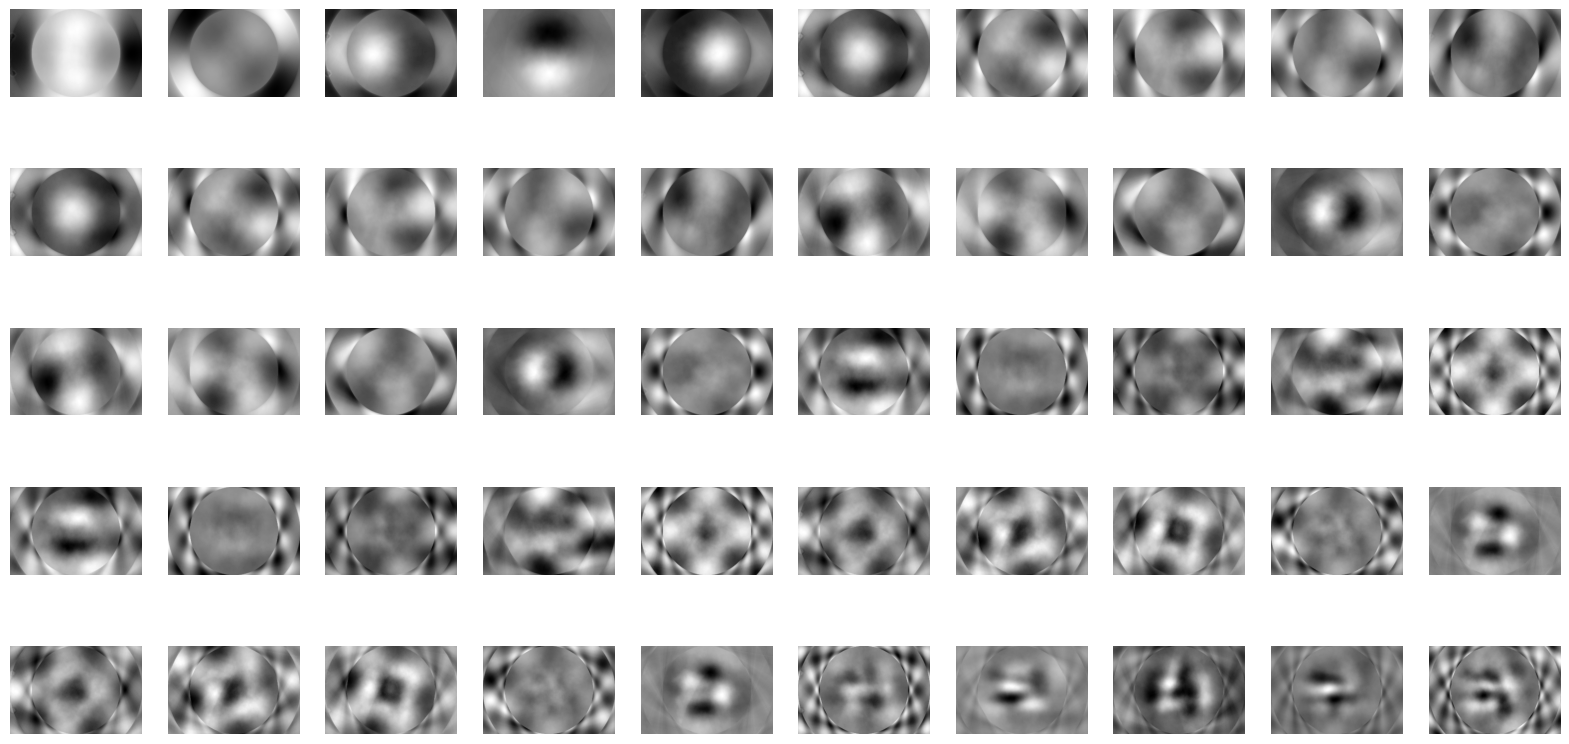

In [34]:
N,M = 5,10
fig, ax = plt.subplots(N, M, figsize=(20,10))
for i in range(N):
    for j in range(M):
        ax[i,j].imshow(pca_model.components_[N*i + j].reshape((200, 300)), cmap='gray')
        ax[i,j].axis('off')
plt.show()

# Training models

## Hyperparameter tuning

For each model we select hyperparameters that maximize mean accuracy measured by cross-validation on training set.

### KNN

#### Full images (needs huge RAM capacity)

In [10]:
# knn_result = optimize_hyperparameters('knn', X_train, y_train, n_trials=100)
# print(knn_result)

In [22]:
best_knn_model = KNeighborsClassifier(n_jobs=-1, n_neighbors=3)
best_knn_model.fit(X_train, y_train)
best_knn_model.score(X_test, y_test)

0.6893203883495146

#### Scaled images

In [14]:
knn_scaled_result = optimize_hyperparameters('knn', X_scaled_train, y_train, n_trials=100)
print(knn_scaled_result)

[I 2024-02-09 11:36:18,959] A new study created in memory with name: no-name-a79b5db7-7c2f-415c-8f8d-31391269f423
[I 2024-02-09 11:36:26,104] Trial 3 finished with value: 0.61790727532097 and parameters: {'n_neighbors': 34}. Best is trial 3 with value: 0.61790727532097.
[I 2024-02-09 11:36:32,526] Trial 0 finished with value: 0.6433348277970247 and parameters: {'n_neighbors': 21}. Best is trial 0 with value: 0.6433348277970247.
[I 2024-02-09 11:36:38,622] Trial 6 finished with value: 0.6433348277970247 and parameters: {'n_neighbors': 21}. Best is trial 0 with value: 0.6433348277970247.
[I 2024-02-09 11:36:44,466] Trial 2 finished with value: 0.67104666802527 and parameters: {'n_neighbors': 8}. Best is trial 2 with value: 0.67104666802527.
[I 2024-02-09 11:36:52,366] Trial 11 finished with value: 0.6507621764825758 and parameters: {'n_neighbors': 19}. Best is trial 2 with value: 0.67104666802527.
[I 2024-02-09 11:36:55,034] Trial 5 finished with value: 0.6376191155492154 and parameters:

FrozenTrial(number=21, state=1, values=[0.6923276951294068], datetime_start=datetime.datetime(2024, 2, 9, 11, 37, 16, 381134), datetime_complete=datetime.datetime(2024, 2, 9, 11, 38, 11, 650152), params={'n_neighbors': 3}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_neighbors': IntDistribution(high=49, log=False, low=3, step=1)}, trial_id=21, value=None)


In [15]:
knn_scaled_result.params

{'n_neighbors': 3}

In [16]:
knn_scaled_result.value

0.6923276951294068

In [17]:
best_knn_model_scaled = KNeighborsClassifier(n_jobs=-1, **knn_scaled_result.params)
best_knn_model_scaled.fit(X_scaled_train, y_train)
best_knn_model_scaled.score(X_scaled_test, y_test)

0.6973158195316962

#### PCA

In [10]:
knn_pca_result = optimize_hyperparameters('knn', X_pca_train, y_train, n_trials=100)
print(knn_pca_result)

[I 2024-02-09 11:35:23,901] A new study created in memory with name: no-name-afef7bde-1bb1-4e7e-be05-018ba109a81f
[I 2024-02-09 11:35:25,678] Trial 7 finished with value: 0.6583317709394743 and parameters: {'n_neighbors': 14}. Best is trial 7 with value: 0.6583317709394743.
[I 2024-02-09 11:35:25,899] Trial 3 finished with value: 0.5923376808640717 and parameters: {'n_neighbors': 41}. Best is trial 7 with value: 0.6583317709394743.
[I 2024-02-09 11:35:25,996] Trial 11 finished with value: 0.6206207458732422 and parameters: {'n_neighbors': 26}. Best is trial 7 with value: 0.6583317709394743.
[I 2024-02-09 11:35:26,016] Trial 0 finished with value: 0.596478907682902 and parameters: {'n_neighbors': 39}. Best is trial 7 with value: 0.6583317709394743.
[I 2024-02-09 11:35:26,056] Trial 4 finished with value: 0.6071921744446709 and parameters: {'n_neighbors': 32}. Best is trial 7 with value: 0.6583317709394743.
[I 2024-02-09 11:35:26,074] Trial 5 finished with value: 0.6701889137966169 and p

FrozenTrial(number=8, state=1, values=[0.7034701446912575], datetime_start=datetime.datetime(2024, 2, 9, 11, 35, 23, 964983), datetime_complete=datetime.datetime(2024, 2, 9, 11, 35, 26, 186717), params={'n_neighbors': 3}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_neighbors': IntDistribution(high=49, log=False, low=3, step=1)}, trial_id=8, value=None)


In [11]:
knn_pca_result.params

{'n_neighbors': 3}

In [12]:
knn_pca_result.value

0.7034701446912575

In [13]:
best_knn_model_pca = KNeighborsClassifier(n_jobs=-1, **knn_pca_result.params)
best_knn_model_pca.fit(X_pca_train, y_train)
best_knn_model_pca.score(X_pca_test, y_test)

0.7070245573957739

### Decision Tree

#### PCA

In [18]:
decision_tree_pca_result = optimize_hyperparameters('decision_tree', X_pca_train, y_train, n_trials=500)
print(decision_tree_pca_result)

[I 2024-02-09 11:47:06,461] A new study created in memory with name: no-name-78cd5442-a842-499b-b96f-ae3b19d61338
[I 2024-02-09 11:47:07,434] Trial 7 finished with value: 0.42293967801100474 and parameters: {'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_leaf_nodes': 16}. Best is trial 7 with value: 0.42293967801100474.
[I 2024-02-09 11:47:08,868] Trial 1 finished with value: 0.5219239861422458 and parameters: {'max_depth': 10, 'min_samples_split': 7, 'min_samples_leaf': 11, 'max_leaf_nodes': 10}. Best is trial 1 with value: 0.5219239861422458.
[I 2024-02-09 11:47:10,410] Trial 2 finished with value: 0.5432054208273894 and parameters: {'max_depth': 25, 'min_samples_split': 9, 'min_samples_leaf': 1, 'max_leaf_nodes': 18}. Best is trial 2 with value: 0.5432054208273894.
[I 2024-02-09 11:47:10,622] Trial 9 finished with value: 0.40337049113511314 and parameters: {'max_depth': 28, 'min_samples_split': 32, 'min_samples_leaf': 15, 'max_leaf_nodes': 3}. Best is trial 2 wi

FrozenTrial(number=176, state=1, values=[0.5642021601793357], datetime_start=datetime.datetime(2024, 2, 9, 11, 51, 10, 620382), datetime_complete=datetime.datetime(2024, 2, 9, 11, 51, 29, 22046), params={'max_depth': 18, 'min_samples_split': 33, 'min_samples_leaf': 14, 'max_leaf_nodes': 30}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'max_depth': IntDistribution(high=30, log=False, low=2, step=1), 'min_samples_split': IntDistribution(high=40, log=False, low=2, step=1), 'min_samples_leaf': IntDistribution(high=20, log=False, low=1, step=1), 'max_leaf_nodes': IntDistribution(high=30, log=False, low=3, step=1)}, trial_id=176, value=None)


In [19]:
decision_tree_pca_result.params

{'max_depth': 18,
 'min_samples_split': 33,
 'min_samples_leaf': 14,
 'max_leaf_nodes': 30}

In [20]:
decision_tree_pca_result.value

0.5642021601793357

In [21]:
best_decision_tree_model_pca = DecisionTreeClassifier(**decision_tree_pca_result.params)
best_decision_tree_model_pca.fit(X_pca_train, y_train)
best_decision_tree_model_pca.score(X_pca_test, y_test)

0.5659623072529982

### Random Forest

#### PCA

In [23]:
random_forest_pca_result = optimize_hyperparameters('random_forest', X_pca_train, y_train, n_trials=100)
print(random_forest_pca_result)

[I 2024-02-09 12:08:16,326] A new study created in memory with name: no-name-cf755f87-1977-4570-8c62-243255b968f7
[I 2024-02-09 12:08:53,646] Trial 0 finished with value: 0.674328306500917 and parameters: {'n_estimators': 146, 'max_depth': 6, 'min_samples_split': 40, 'min_samples_leaf': 18, 'max_leaf_nodes': 25}. Best is trial 0 with value: 0.674328306500917.
[I 2024-02-09 12:10:40,093] Trial 8 finished with value: 0.7341801508049726 and parameters: {'n_estimators': 216, 'max_depth': 29, 'min_samples_split': 20, 'min_samples_leaf': 15, 'max_leaf_nodes': 61}. Best is trial 8 with value: 0.7341801508049726.
[I 2024-02-09 12:10:55,814] Trial 6 finished with value: 0.6627607499490524 and parameters: {'n_estimators': 899, 'max_depth': 47, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_leaf_nodes': 13}. Best is trial 8 with value: 0.7341801508049726.
[I 2024-02-09 12:11:01,061] Trial 1 finished with value: 0.64490666394946 and parameters: {'n_estimators': 494, 'max_depth': 23, 'min_samp

FrozenTrial(number=27, state=1, values=[0.7493209700427961], datetime_start=datetime.datetime(2024, 2, 9, 12, 16, 20, 740841), datetime_complete=datetime.datetime(2024, 2, 9, 12, 24, 58, 322299), params={'n_estimators': 999, 'max_depth': 69, 'min_samples_split': 28, 'min_samples_leaf': 4, 'max_leaf_nodes': 70}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=1000, log=False, low=100, step=1), 'max_depth': IntDistribution(high=70, log=False, low=2, step=1), 'min_samples_split': IntDistribution(high=40, log=False, low=2, step=1), 'min_samples_leaf': IntDistribution(high=20, log=False, low=1, step=1), 'max_leaf_nodes': IntDistribution(high=70, log=False, low=3, step=1)}, trial_id=27, value=None)


In [24]:
random_forest_pca_result.params

{'n_estimators': 999,
 'max_depth': 69,
 'min_samples_split': 28,
 'min_samples_leaf': 4,
 'max_leaf_nodes': 70}

In [25]:
random_forest_pca_result.value

0.7493209700427961

In [26]:
best_random_forest_model_pca = RandomForestClassifier(**random_forest_pca_result.params)
best_random_forest_model_pca.fit(X_pca_train, y_train)
best_random_forest_model_pca.score(X_pca_test, y_test)

0.7498572244431754

### SVM

#### PCA

In [11]:
svm_pca_result = optimize_hyperparameters('svm', X_pca_train, y_train, n_trials=5)
print(svm_pca_result)

[I 2024-02-09 15:07:11,684] A new study created in memory with name: no-name-8fd5a88c-529a-497c-a20c-20c9b6cb92cb
[I 2024-02-09 15:08:08,548] Trial 3 finished with value: 0.7686011819849196 and parameters: {'C': 36.084379418599504, 'kernel': 'poly', 'gamma': 0.6591272530484011, 'degree': 5}. Best is trial 3 with value: 0.7686011819849196.
[I 2024-02-09 15:08:36,466] Trial 4 finished with value: 0.7837446504992868 and parameters: {'C': 33.23813368092139, 'kernel': 'poly', 'gamma': 0.6083022151021312, 'degree': 4}. Best is trial 4 with value: 0.7837446504992868.
[I 2024-02-09 15:08:52,413] Trial 0 finished with value: 0.7598897493376808 and parameters: {'C': 84.26105309575149, 'kernel': 'poly', 'gamma': 0.4639450237397912, 'degree': 6}. Best is trial 4 with value: 0.7837446504992868.
[I 2024-02-09 15:08:55,833] Trial 2 finished with value: 0.7781746484613817 and parameters: {'C': 45.83390517638546, 'kernel': 'poly', 'gamma': 0.6218791614764817, 'degree': 2}. Best is trial 4 with value: 0

FrozenTrial(number=4, state=1, values=[0.7837446504992868], datetime_start=datetime.datetime(2024, 2, 9, 15, 7, 11, 691293), datetime_complete=datetime.datetime(2024, 2, 9, 15, 8, 36, 465758), params={'C': 33.23813368092139, 'kernel': 'poly', 'gamma': 0.6083022151021312, 'degree': 4}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'C': FloatDistribution(high=100.0, log=False, low=0.05, step=None), 'kernel': CategoricalDistribution(choices=('poly',)), 'gamma': FloatDistribution(high=1.0, log=False, low=1e-05, step=None), 'degree': IntDistribution(high=9, log=False, low=2, step=1)}, trial_id=4, value=None)


In [12]:
svm_pca_result.params

{'C': 33.23813368092139,
 'kernel': 'poly',
 'gamma': 0.6083022151021312,
 'degree': 4}

In [13]:
svm_pca_result.value

0.7837446504992868

In [14]:
best_svm_model_pca = SVC(**svm_pca_result.params)
best_svm_model_pca.fit(X_pca_train, y_train)
best_svm_model_pca.score(X_pca_test, y_test)

0.7829811536264991

### XGBoost

#### PCA

In [35]:
xgboost_pca_result = optimize_hyperparameters('xgboost', X_pca_train, y_train, n_trials=100)
print(xgboost_pca_result)

[I 2024-02-09 15:59:48,218] A new study created in memory with name: no-name-f778e48f-41c3-4be7-8114-58aea83df722
[I 2024-02-09 16:03:26,410] Trial 5 finished with value: 0.8363095577746078 and parameters: {'max_depth': 8, 'n_estimators': 82, 'learning_rate': 0.1397727842922849, 'subsample': 0.6489132716949267, 'reg_alpha': 2.67821014446334, 'reg_lambda': 2.320094546843911}. Best is trial 5 with value: 0.8363095577746078.
[I 2024-02-09 16:05:13,456] Trial 6 finished with value: 0.8410232321173833 and parameters: {'max_depth': 4, 'n_estimators': 160, 'learning_rate': 0.1346163464234354, 'subsample': 0.674387340499409, 'reg_alpha': 0.6134124998943652, 'reg_lambda': 4.837202422505189}. Best is trial 6 with value: 0.8410232321173833.
[I 2024-02-09 16:05:45,531] Trial 8 finished with value: 0.79774485428979 and parameters: {'max_depth': 9, 'n_estimators': 58, 'learning_rate': 0.06620303396912497, 'subsample': 0.9499457870955678, 'reg_alpha': 0.3778509350913345, 'reg_lambda': 2.5578863698589

FrozenTrial(number=67, state=1, values=[0.8628771143264725], datetime_start=datetime.datetime(2024, 2, 9, 17, 12, 24, 217424), datetime_complete=datetime.datetime(2024, 2, 9, 17, 29, 57, 708617), params={'max_depth': 8, 'n_estimators': 279, 'learning_rate': 0.17829011545082676, 'subsample': 0.9124282632963587, 'reg_alpha': 2.255571162185187, 'reg_lambda': 4.323513303870824}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'max_depth': IntDistribution(high=12, log=False, low=3, step=1), 'n_estimators': IntDistribution(high=300, log=False, low=50, step=1), 'learning_rate': FloatDistribution(high=0.2, log=False, low=0.01, step=None), 'subsample': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'reg_alpha': FloatDistribution(high=5.0, log=False, low=0.0, step=None), 'reg_lambda': FloatDistribution(high=5.0, log=False, low=0.0, step=None)}, trial_id=67, value=None)


In [36]:
xgboost_pca_result.params

{'max_depth': 8,
 'n_estimators': 279,
 'learning_rate': 0.17829011545082676,
 'subsample': 0.9124282632963587,
 'reg_alpha': 2.255571162185187,
 'reg_lambda': 4.323513303870824}

In [37]:
xgboost_pca_result.value

0.8628771143264725

In [38]:
best_xgboost_model_pca = XGBClassifier(**xgboost_pca_result.params)
best_xgboost_model_pca.fit(X_pca_train, y_train)
best_xgboost_model_pca.score(X_pca_test, y_test)

0.8772130211307824